In [54]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import joblib
import google.generativeai as genai
import os

In [55]:
# Load the dataset
df = pd.read_excel("corrections2.xlsx", sheet_name="Réponses au formulaire 1")

In [56]:
df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39 entries, 0 to 38
Data columns (total 44 columns):
 #   Column                                                Non-Null Count  Dtype         
---  ------                                                --------------  -----         
 0   Horodateur                                            39 non-null     datetime64[ns]
 1   nom prénom                                            39 non-null     object        
 2   numero du dossier                                     39 non-null     object        
 3   date de l'intervention                                39 non-null     datetime64[ns]
 4   Age lors de l'intervention                            39 non-null     int64         
 5   sexe                                                  39 non-null     int64         
 6   IMC (Kg/m2)                                           37 non-null     object        
 7   SC (m2)                                               38 non-null     float64     

In [57]:
df.tail()

,Horodateur,nom prénom,numero du dossier,date de l'intervention,Age lors de l'intervention,sexe,IMC (Kg/m2),SC (m2),OBESITE,Comorbidités,...,Durée de séjour total,Décès en post-opératoire,masse VG g/m2,Surface valvulaire aortique indexée : cm²/m2,ANATOMIE DE LA VALVE ECHO,ANATOMIE DE LA VALVE CHIRURGIE,STRAIN VG GLS : %,ATCD CHIRURGICAUX CARDIAQUES,CHIRURGIE CARDIAQUE PRECEDENTE:,DIAMETRE SOUS AO OU ANNEAU AO
34,2025-05-01 18:18:52,MECENE Ayoub,138/2024,2024-05-27,19,1,16,1.70,0.0,0,...,30,0,163.00,0.39,BICUSPIDE,BICUSPIDE,NaN,NaN,NaN,NaN
35,2025-05-02 11:47:12,CHIKHAOUI MESSOUDA,061/2023,2023-03-26,46,0,34.9,2.02,1.0,0,...,3,1,84.00,0.30,TRICUSPIDE,TRICUSPIDE,NaN,NaN,NaN,NaN
36,2025-05-02 12:36:12,BELAHDJEL CHAMSEDDINE,260/2023,2023-12-27,27,1,20,1.66,0.0,0,...,23,0,169.00,0.50,BICUSPIDE,BICUSPIDE,-3.2,REDUX,STENOSE SUPRAVALVULAIRE AO OPEREE 2009 ELARGIS...,24.0
37,2025-05-02 22:48:37,BENZAOUI TAYEB,094/2023,2023-06-15,65,1,27.7,1.92,0.0,0,...,43,0,147.39,0.30,NaN,NaN,NaN,NaN,NaN,21.0
38,2025-05-02 23:00:31,BOUDEJLJEL Ameur,114/2023,2023-06-11,44,1,2025-01-29 00:00:00,2.06,0.0,0,...,26,0,133.06,0.50,NaN,NaN,NaN,1ERE CHIRURGIE,NaN,22.0


In [58]:
def perturb_dates(df, date_columns, days_range=7):
    df_aug = df.copy()
    for col in date_columns:
        if pd.api.types.is_datetime64_any_dtype(df[col]):
            days_noise = np.random.randint(-days_range, days_range, len(df))
            df_aug[col] = df[col] + pd.to_timedelta(days_noise, unit='D')
    return df_aug

date_cols = ['date de l\'intervention']
aug_df = perturb_dates(df, date_cols)

In [59]:
medication_db = ['Aspirin', 'Metoprolol', 'Atorvastatin', 'Warfarin', 
                'Furosemide', 'Ramipril', 'Insulin']

def augment_medications(df, med_column):
    df_aug = df.copy()
    for i, row in df.iterrows():
        if pd.notna(row[med_column]):
            meds = str(row[med_column]).split(', ')
            if len(meds) > 0 and np.random.random() > 0.7:
                new_med = np.random.choice(medication_db)
                if new_med not in meds:
                    meds.append(new_med)
                df_aug.at[i, med_column] = ', '.join(meds)
    return df_aug

In [60]:
# Check data types
print(df.dtypes)

# Check mixed-type columns
for col in df.columns:
    unique_types = set(type(x) for x in df[col])
    if len(unique_types) > 1:
        print(f"Column '{col}' has mixed types: {unique_types}")

Horodateur                                              datetime64[ns]
nom prénom                                                      object
numero du dossier                                               object
date de l'intervention                                  datetime64[ns]
Age lors de l'intervention                                       int64
sexe                                                             int64
IMC (Kg/m2)                                                     object
SC (m2)                                                        float64
OBESITE                                                        float64
Comorbidités                                                     int64
Traitements médicamenteux  pré-opératoires :                    object
Surface valvulaire aortique : cm²                              float64
Vitesse max :     m/s                                          float64
Gradient moyen transvalvulaire : mmHg                            int64
Fracti

In [61]:
import pandas as pd
import numpy as np
from faker import Faker
import random

# Load Algerian names
with open('algerian_names.txt', 'r') as f:
    algerian_names = [line.strip() for line in f.readlines()]

# Function to get unique random Algerian names
def get_unique_names(count, used_names):
    available_names = [name for name in algerian_names if name not in used_names]
    if len(available_names) < count:
        raise ValueError("Not enough unique Algerian names available")
    return random.sample(available_names, count)


In [62]:
def augment_medications(df, med_column):
    medication_db = ['Aspirin', 'Metoprolol', 'Atorvastatin', 'Warfarin', 
                    'Furosemide', 'Ramipril', 'Insulin']
    
    df_aug = df.copy()
    for i, row in df.iterrows():
        if pd.notna(row[med_column]):
            meds = str(row[med_column]).split(', ')
            if len(meds) > 0 and np.random.random() > 0.7:
                new_med = np.random.choice(medication_db)
                if new_med not in meds:
                    meds.append(new_med)
                df_aug.at[i, med_column] = ', '.join(meds)
    return df_aug

In [63]:
def medical_augmentation_pipeline(df, augmentation_factor=2):
    # Get all currently used names
    used_names = set(df['nom prénom'].tolist())
    
    # Get numeric columns (excluding datetime and strings)
    numeric_cols = [col for col in df.columns 
                   if pd.api.types.is_numeric_dtype(df[col]) 
                   and not pd.api.types.is_datetime64_any_dtype(df[col])]
    
    # Get date columns
    date_cols = [col for col in df.columns 
                if pd.api.types.is_datetime64_any_dtype(df[col])]
    
    # Get categorical columns (excluding dates and numbers)
    cat_cols = [col for col in df.columns 
               if not pd.api.types.is_numeric_dtype(df[col]) 
               and not pd.api.types.is_datetime64_any_dtype(df[col]) 
               and col not in ['nom prénom', 'numero du dossier', 'Horodateur']]
    
    augmented_dfs = []
    
    for _ in range(augmentation_factor):
        temp_df = df.copy()
        
        # Generate unique Algerian names for this augmentation batch
        new_names = get_unique_names(len(df), used_names)
        used_names.update(new_names)
        temp_df['nom prénom'] = new_names
        
        # Generate unique dossier numbers
        base_numbers = [int(x.split('/')[0]) for x in df['numero du dossier']]
        max_num = max(base_numbers)
        new_numbers = [f"{max_num + i + 1}/2024" for i in range(len(df))]
        temp_df['numero du dossier'] = new_numbers
        
        # Numerical augmentation
        for col in numeric_cols:
            if pd.notna(df[col]).any():  # Only augment if not all NaN
                noise = np.random.normal(0, 0.03 * df[col].std(), len(df))
                temp_df[col] = df[col] + noise
        
        # Categorical augmentation
        for col in cat_cols:
            unique_vals = df[col].dropna().unique()
            if len(unique_vals) > 0:
                mask = np.random.random(len(df)) > 0.7
                temp_df.loc[mask, col] = np.random.choice(unique_vals, size=mask.sum())
        
        # Date perturbation
        for col in date_cols:
            days_noise = np.random.randint(-5, 5, len(df))
            temp_df[col] = df[col] + pd.to_timedelta(days_noise, unit='D')
        
        # Medication augmentation if column exists
        med_col = 'Traitements médicamenteux  pré-opératoires :'
        if med_col in temp_df.columns:
            temp_df = augment_medications(temp_df, med_col)
        
        augmented_dfs.append(temp_df)
    
    final_df = pd.concat([df] + augmented_dfs, ignore_index=True)
    
    # Post-processing with proper type checking
    if 'IMC (Kg/m2)' in final_df.columns and pd.api.types.is_numeric_dtype(final_df['IMC (Kg/m2)']):
        final_df['IMC (Kg/m2)'] = pd.to_numeric(final_df['IMC (Kg/m2)'], errors='coerce')
        final_df['IMC (Kg/m2)'] = final_df['IMC (Kg/m2)'].clip(lower=15, upper=50)
    
    if 'Age lors de l\'intervention' in final_df.columns and pd.api.types.is_numeric_dtype(final_df['Age lors de l\'intervention']):
        final_df['Age lors de l\'intervention'] = pd.to_numeric(final_df['Age lors de l\'intervention'], errors='coerce')
        final_df['Age lors de l\'intervention'] = final_df['Age lors de l\'intervention'].clip(lower=18, upper=100)
    
    return final_df

In [64]:
# Apply augmentation
final_augmented_df = medical_augmentation_pipeline(df, augmentation_factor=3)
final_augmented_df.drop_duplicates()
final_augmented_df.tail()


,Horodateur,nom prénom,numero du dossier,date de l'intervention,Age lors de l'intervention,sexe,IMC (Kg/m2),SC (m2),OBESITE,Comorbidités,...,Durée de séjour total,Décès en post-opératoire,masse VG g/m2,Surface valvulaire aortique indexée : cm²/m2,ANATOMIE DE LA VALVE ECHO,ANATOMIE DE LA VALVE CHIRURGIE,STRAIN VG GLS : %,ATCD CHIRURGICAUX CARDIAQUES,CHIRURGIE CARDIAQUE PRECEDENTE:,DIAMETRE SOUS AO OU ANNEAU AO
151,2025-05-05 18:18:52,MEBARKI Khaled,304/2024,2024-05-29,18.169035,0.999068,16,1.699322,0.007013,-0.081194,...,31.248711,-0.001160,165.124486,0.390043,BICUSPIDE,BICUSPIDE,-18.4,NaN,NaN,NaN
152,2025-05-02 11:47:12,SAADI Abdelkader,305/2024,2023-03-25,45.520978,-0.004607,34.9,2.006195,1.002072,0.073781,...,4.145984,1.003579,83.173566,0.300309,TRICUSPIDE,TRICUSPIDE,-18.4,NaN,STENOSE SUPRAVALVULAIRE AO OPEREE 2009 ELARGIS...,NaN
153,2025-04-29 12:36:12,BELKACEM Farid,306/2024,2023-12-23,26.800779,1.002483,20,1.670622,0.016398,-0.008165,...,22.780601,0.002668,168.162788,0.508735,BICUSPIDE,BICUSPIDE,-12,REDUX,STENOSE SUPRAVALVULAIRE AO OPEREE 2009 ELARGIS...,23.995072
154,2025-05-03 22:48:37,BENAISSA Yasmine,307/2024,2023-06-16,65.725342,1.018770,26.9,1.922766,-0.021089,-0.024209,...,42.612200,0.016101,144.417659,0.301091,NaN,BICUSPIDE,NaN,NaN,NaN,21.031187
155,2025-04-30 23:00:31,KHALIFI Mourad,308/2024,2023-06-09,44.366857,0.987255,2025-01-29 00:00:00,2.053149,0.005611,0.032964,...,25.540856,-0.006645,134.688579,0.504354,TRICUSPIDE,NaN,NaN,REDUX,NaN,21.957355


In [65]:
# Verify unique names
print(f"Original names: {len(set(df['nom prénom']))}")
print(f"Augmented names: {len(set(final_augmented_df['nom prénom']))}")
print(f"Total unique names used: {len(set(final_augmented_df['nom prénom']))}")

# Check dossier numbers
print("\nSample dossier numbers:")
print(final_augmented_df['numero du dossier'].tail(10))

Original names: 39
Augmented names: 153
Total unique names used: 153

Sample dossier numbers:
146    299/2024
147    300/2024
148    301/2024
149    302/2024
150    303/2024
151    304/2024
152    305/2024
153    306/2024
154    307/2024
155    308/2024
Name: numero du dossier, dtype: object


In [66]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt



In [67]:
df = final_augmented_df.copy()
df.dropna()
df.drop_duplicates()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156 entries, 0 to 155
Data columns (total 44 columns):
 #   Column                                                Non-Null Count  Dtype         
---  ------                                                --------------  -----         
 0   Horodateur                                            156 non-null    datetime64[ns]
 1   nom prénom                                            156 non-null    object        
 2   numero du dossier                                     156 non-null    object        
 3   date de l'intervention                                156 non-null    datetime64[ns]
 4   Age lors de l'intervention                            156 non-null    float64       
 5   sexe                                                  156 non-null    float64       
 6   IMC (Kg/m2)                                           149 non-null    object        
 7   SC (m2)                                               152 non-null    float64   

In [68]:
# Buildingthemodel
target_col = 'Complications post-opératoires précoces (< 30 jours)'
y = df[target_col].astype(int)  # Ensure target is integer
X = df.drop(columns=[target_col])

# 2. Preprocessing
# Convert datetime columns to numeric (days since min date)
datetime_cols = X.select_dtypes(include=['datetime64']).columns
for col in datetime_cols:
    X[col] = (X[col] - X[col].min()).dt.days

# Numeric features
numeric_cols = X.select_dtypes(include=['number']).columns
X[numeric_cols] = SimpleImputer(strategy='median').fit_transform(X[numeric_cols])

# Categorical features
cat_cols = X.select_dtypes(include=['object']).columns
for col in cat_cols:
    X[col] = LabelEncoder().fit_transform(X[col].astype(str))

In [69]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [70]:
print("=== Random Forest Regressor ===")
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

=== Random Forest Regressor ===


In [71]:
print(f"MSE: {mean_squared_error(y_test, rf_pred):.2f}")
print(f"MAE: {mean_absolute_error(y_test, rf_pred):.2f}")
print(f"R²: {r2_score(y_test, rf_pred):.2f}")


MSE: 0.24
MAE: 0.37
R²: 0.93


In [72]:
print("\n=== Decision Tree Regressor ===")
dt = DecisionTreeRegressor(max_depth=5, random_state=42)
dt.fit(X_train, y_train)
dt_pred = dt.predict(X_test)


=== Decision Tree Regressor ===


In [73]:
print(f"MSE: {mean_squared_error(y_test, dt_pred):.2f}")
print(f"MAE: {mean_absolute_error(y_test, dt_pred):.2f}")
print(f"R²: {r2_score(y_test, dt_pred):.2f}")

MSE: 0.13
MAE: 0.17
R²: 0.96


In [74]:
# 5. Feature importance
print("\nTop 10 Important Features (Random Forest):")
print(pd.Series(rf.feature_importances_, index=X.columns)
      .sort_values(ascending=False).head(10))


Top 10 Important Features (Random Forest):
Volume télésystolique VG : ml/m2                0.445046
Durée de séjour  en reanimation                 0.107665
Durée de séjour en unite post opératoire        0.101115
Fraction d’éjection VG post op: %               0.058072
Gradient moyen protheses : mmHg                 0.047096
Volume OG : ml/m2                               0.043176
Volume télédiastolique VG :  ml/m2              0.037949
Comorbidités                                    0.022091
Traitements médicamenteux  pré-opératoires :    0.017032
Surface valvulaire aortique : cm²               0.012174
dtype: float64


In [75]:
# Initialize models
models = {
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Decision Tree": DecisionTreeRegressor(max_depth=5, random_state=42)
}

# Evaluate models
results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    results.append({
        'Model': name,
        'MSE': mean_squared_error(y_test, y_pred),
        'RMSE': mean_squared_error(y_test, y_pred),
        'MAE': mean_absolute_error(y_test, y_pred),
        'R²': r2_score(y_test, y_pred)
    })
results_df = pd.DataFrame(results).set_index('Model')
# Display metrics comparison
print("=== Model Performance Comparison ===")
print(results_df)

=== Model Performance Comparison ===
                    MSE      RMSE       MAE        R²
Model                                                
Random Forest  0.235397  0.235397  0.367188  0.925326
Decision Tree  0.134692  0.134692  0.165465  0.957272


In [76]:
plt.figure(figsize=(12, 6))

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

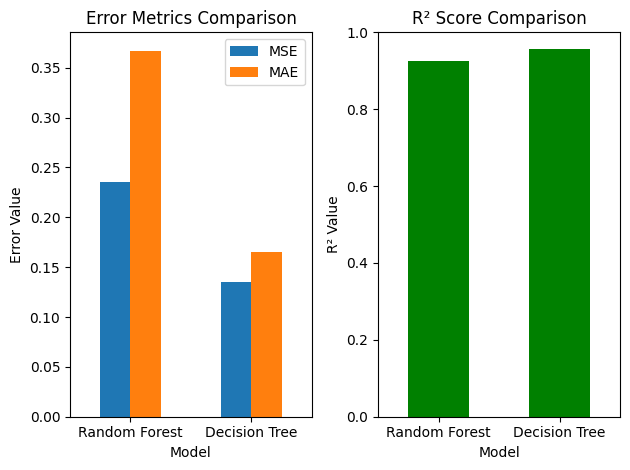

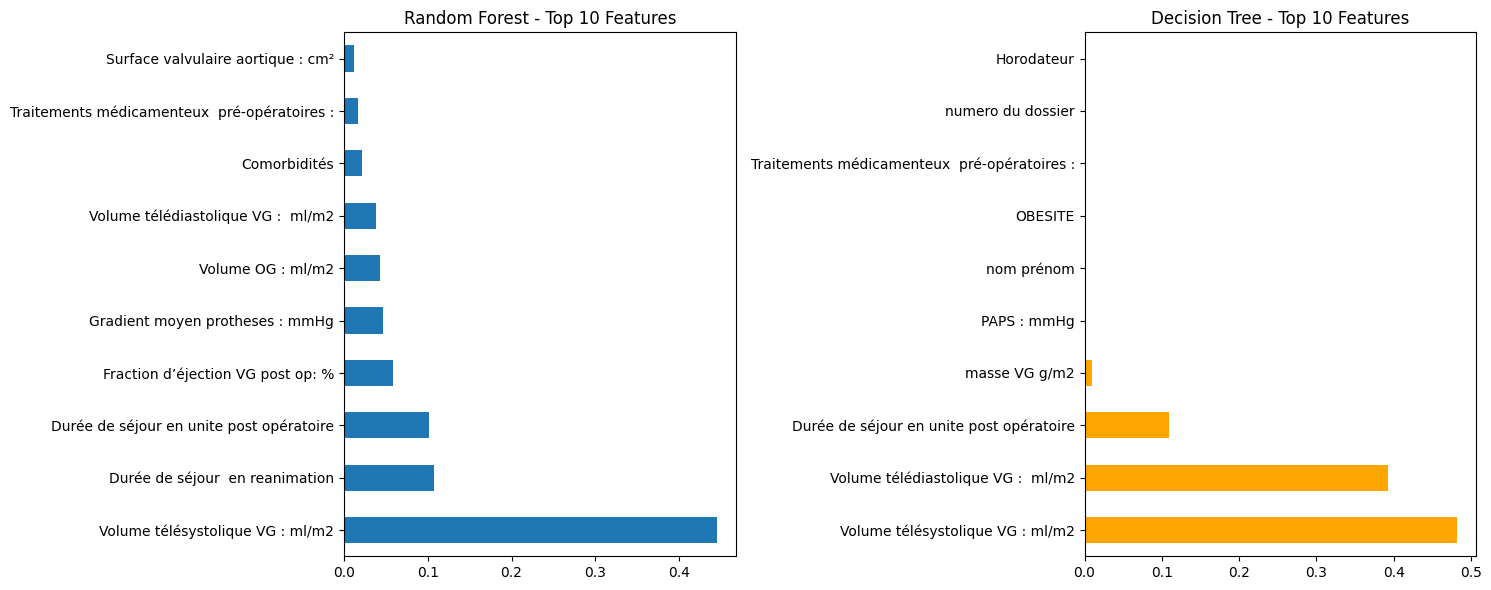

,MSE,RMSE,MAE,R²
Model,,,,
Random Forest,0.235397,0.235397,0.367188,0.925326
Decision Tree,0.134692,0.134692,0.165465,0.957272


In [77]:
# Metrics plot
plt.subplot(1, 2, 1)
results_df[['MSE', 'MAE']].plot(kind='bar', ax=plt.gca())
plt.title('Error Metrics Comparison')
plt.ylabel('Error Value')
plt.xticks(rotation=0)

# R² plot
plt.subplot(1, 2, 2)
results_df['R²'].plot(kind='bar', color='green', ax=plt.gca())
plt.title('R² Score Comparison')
plt.ylabel('R² Value')
plt.xticks(rotation=0)
plt.ylim(0, 1)

plt.tight_layout()
plt.show()

# Feature importance comparison
plt.figure(figsize=(15, 6))

# Random Forest feature importance
plt.subplot(1, 2, 1)
rf_feat_imp = pd.Series(models["Random Forest"].feature_importances_, index=X.columns)
rf_feat_imp.nlargest(10).plot(kind='barh')
plt.title('Random Forest - Top 10 Features')

# Decision Tree feature importance
plt.subplot(1, 2, 2)
dt_feat_imp = pd.Series(models["Decision Tree"].feature_importances_, index=X.columns)
dt_feat_imp.nlargest(10).plot(kind='barh', color='orange')
plt.title('Decision Tree - Top 10 Features')

plt.tight_layout()
plt.show()

# Return the comparison dataframe
results_df